# Imports

Buncha imports

In [1]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
# from tensorflow.keras.layers import Batchnorm2D, Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Loading CSV's containing image path stuff

Lets make a var for our main directory

In [3]:
path = '../input/cassava-leaf-disease-classification/'

Loading of the train csv

In [4]:
train_csv = pd.read_csv(path + 'train.csv')
train_csv.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


lets see how many samples do we have

In [5]:
train_csv.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

- The image path is not compelete we would like it to be compelete

- The labels are not one hot encoded

So the plan - 

- make a function to compelete the path
- make a function to convert into one hot arrays
- use ```train_csv.apply()```

In [6]:
def comp_path(img_name):
    img_dir = '../input/cassava-leaf-disease-classification/train_images/'
    return img_dir + img_name
def one_hot(label):
    return str(list(to_categorical(label, num_classes=5, dtype='int32')))

Please run the following cells only once.

In [7]:
train_csv.image_id = train_csv.image_id.apply(comp_path)
print(train_csv.image_id[0])

../input/cassava-leaf-disease-classification/train_images/1000015157.jpg


In [8]:
train_csv.label = train_csv.label.apply(one_hot)
train_csv

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,"[1, 0, 0, 0, 0]"
1,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
2,../input/cassava-leaf-disease-classification/t...,"[0, 1, 0, 0, 0]"
3,../input/cassava-leaf-disease-classification/t...,"[0, 1, 0, 0, 0]"
4,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
...,...,...
21392,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
21393,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
21394,../input/cassava-leaf-disease-classification/t...,"[0, 1, 0, 0, 0]"
21395,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 0, 1]"


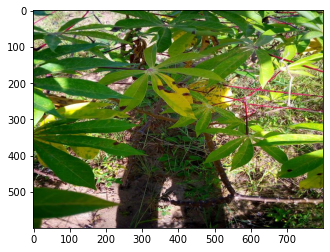

In [9]:
img = cv2.imread(train_csv.image_id[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Let us now split our dataframe into train and validation sets

In [10]:
from sklearn.model_selection import train_test_split

train,val = train_test_split(train_csv, test_size = 0.1, random_state = 42)


In [11]:
train.head()

,image_id,label
9595,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
14476,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
14882,../input/cassava-leaf-disease-classification/t...,"[0, 1, 0, 0, 0]"
13098,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
19081,../input/cassava-leaf-disease-classification/t...,"[0, 1, 0, 0, 0]"


In [12]:
val.head()

,image_id,label
9134,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 0, 1]"
1580,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
7304,../input/cassava-leaf-disease-classification/t...,"[0, 0, 0, 1, 0]"
13196,../input/cassava-leaf-disease-classification/t...,"[0, 0, 1, 0, 0]"
5333,../input/cassava-leaf-disease-classification/t...,"[0, 0, 1, 0, 0]"


In [13]:
from collections import Counter
print(Counter(train.label.apply(str)))

Counter({'[0, 0, 0, 1, 0]': 11812, '[0, 0, 0, 0, 1]': 2320, '[0, 0, 1, 0, 0]': 2143, '[0, 1, 0, 0, 0]': 1988, '[1, 0, 0, 0, 0]': 994})


In [14]:
print(Counter(val.label.apply(str)))

Counter({'[0, 0, 0, 1, 0]': 1346, '[0, 0, 0, 0, 1]': 257, '[0, 0, 1, 0, 0]': 243, '[0, 1, 0, 0, 0]': 201, '[1, 0, 0, 0, 0]': 93})


A look at our classes

In [15]:
labels = pd.read_json(path + 'label_num_to_disease_map.json', orient='index')
labels

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


Lets have a sneak peek at the submission file

In [16]:
pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

,image_id,label
0,2216849948.jpg,4


# Load in Data and Augmentations

Will need augmentations to increase amount of data.

Good augmentations for detecting a disease is that does not alters the disease's features.
So some ot the good augmentations would be - 

**1. Vertical Flip**

**2. Horrizontal Flip**

**3. Rotation**

**4. Zoom the image**

**5. Centre crop**

## Parameters for training - 

In [31]:
BATCH_SIZE = 32
EPOCHS = 15
IMG_SIZE = 256

Setting some augmentation parameters in an ImageDataGenerator Object

In [32]:
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                    vertical_flip = True, 
                                    height_shift_range=0.2, 
                                    width_shift_range=0.2, 
                                    brightness_range=[0.7, 1.5],
                                    rotation_range=30, 
                                    shear_range=0.2,
                                    fill_mode='reflect',
                                    zoom_range=[0.3,0.6],
                                  )

Making the generator and telling it where to look for the data

In [33]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train,
                                             directory = None,
                                             x_col = "image_id",
                                             y_col = "label",
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")


Found 19257 validated image filenames belonging to 5 classes.


Lets display the images. Here is our function to display images

In [37]:
t_x, t_y = next(train_gen)

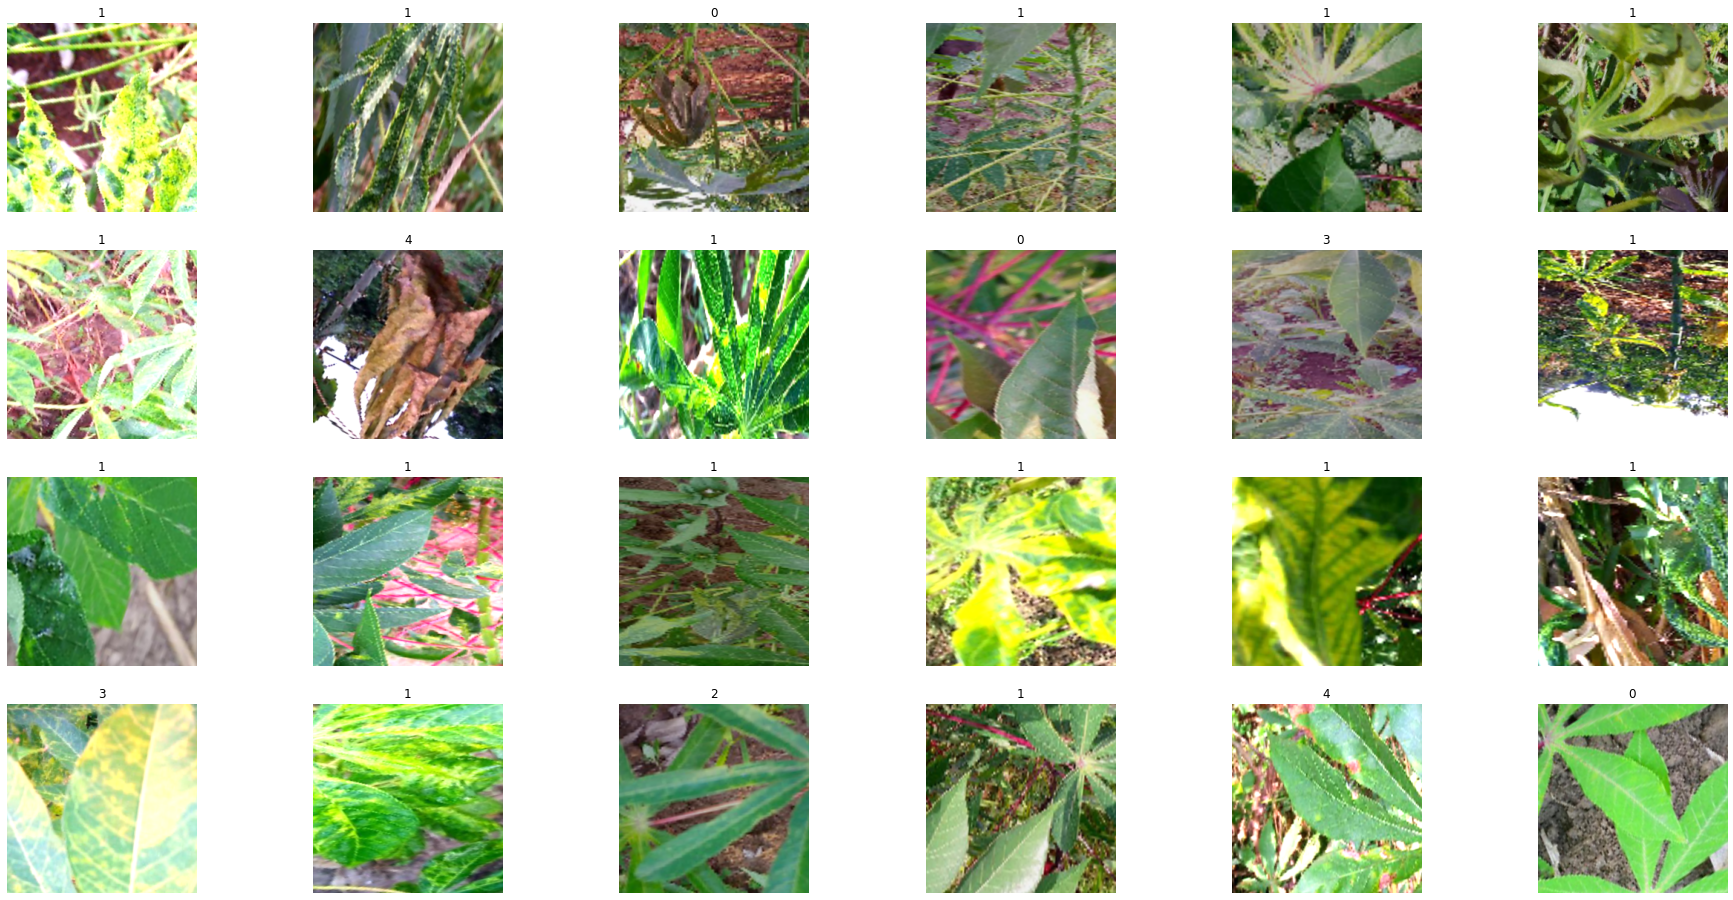

In [38]:
fig, m_axs = plt.subplots(4, 6, figsize = (32, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x.astype(np.uint8))
    c_ax.set_title(np.argmax(c_y))
    c_ax.axis('off')

In [39]:
t_y[0]

array([0., 1., 0., 0., 0.], dtype=float32)

The validation generator - 

In [40]:
val_datagen = ImageDataGenerator(horizontal_flip = True, 
                                vertical_flip = True, 
                                height_shift_range=0.2, 
                                width_shift_range=0.2, 
                                brightness_range=[0.7, 1.5],
                                rotation_range=30, 
                                shear_range=0.2,
                                fill_mode='reflect',
                                zoom_range=[0.3,0.6],
                                  )

In [41]:
val_gen = train_datagen.flow_from_dataframe(dataframe = val,
                                             directory = None,
                                             x_col = "image_id",
                                             y_col = "label",
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")


Found 2140 validated image filenames belonging to 5 classes.


# The Model - 

Ok so we have made our augmentors and stuff loaded in data and stuff and now making the model and stuff is left.

First step lets load in the state of the art Efficientnet B4 model. Well lets see if it turns 
state of the art in helping us sort out the cassava disease.

This sure is a wonderful tutorial - 

https://www.kaggle.com/harveenchadha/effnetb4-tf-data-gpu-aug-5x-speedup-tta?select=best_model.hdf5

In [42]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None
    print('Not RUNNING on TPU')

if tpu:
    print('MAKING TPU STRATEGY')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    print('MAKING CPU STRATEGY')
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Not RUNNING on TPU
MAKING CPU STRATEGY
REPLICAS: 1


In [43]:
#!wget https://storage.googleapis.com/keras-applications/efficientnetb4_notop.h5

In [44]:
def make_model():
    model = Sequential()
    model.add(efn.EfficientNetB4(include_top = False,
                                  weights = 'noisy-student',
                                  pooling = 'avg',
                                  input_shape = (IMG_SIZE, IMG_SIZE, 3)))
    model.add(Dense(5, activation = 'softmax'))
    model.layers[0].trainable = True
    
    optimizer = Adam(lr = 0.01)
    #tpu_optimizer = tf.experimental.contrib.tpu.CrossShardOptimizer(optimizer)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [45]:
model = make_model()

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 8965      
Total params: 17,682,781
Trainable params: 17,557,581
Non-trainable params: 125,200
_________________________________________________________________


In [47]:
# Callbacks
model_path = 'EnetB4_top_trainable/'
tensorboard = TensorBoard(log_dir = model_path + 'logs/')
reducelr = ReduceLROnPlateau(patience=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience = 3, mode = 'min')
checkpoint_val_loss = ModelCheckpoint(model_path + 'val_loss_checkpoint/{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, mode='min')
checkpoint_val_acc = ModelCheckpoint(model_path + 'val_acc_checkpoint/{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_acc', save_best_only=True, mode='max')
checkpoint_all = ModelCheckpoint(model_path + 'all_checkpoint/{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=False, mode='auto')
best = ModelCheckpoint(model_path + 'best_model.hdf5', monitor='val_loss', save_best_only=True, mode='min')

In [48]:
history = model.fit(train_gen,
                    validation_data = val_gen,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [tensorboard, 
                                 reducelr, earlystop, 
                                 checkpoint_val_loss, checkpoint_val_acc, 
                                 checkpoint_all,
                                 best])

Epoch 1/15
602/602 [==============================] - 731s 1s/step - loss: 1.0753 - accuracy: 0.6246 - val_loss: 2.4882 - val_accuracy: 0.2136
Epoch 2/15
602/602 [==============================] - 645s 1s/step - loss: 0.9117 - accuracy: 0.6552 - val_loss: 1.3014 - val_accuracy: 0.5262
Epoch 3/15
602/602 [==============================] - 644s 1s/step - loss: 0.8506 - accuracy: 0.6806 - val_loss: 0.9473 - val_accuracy: 0.6407
Epoch 4/15
602/602 [==============================] - 643s 1s/step - loss: 0.8025 - accuracy: 0.7022 - val_loss: 1.1048 - val_accuracy: 0.6346
Epoch 5/15
602/602 [==============================] - 645s 1s/step - loss: 0.6818 - accuracy: 0.7541 - val_loss: 0.6199 - val_accuracy: 0.7743
Epoch 6/15
602/602 [==============================] - 644s 1s/step - loss: 0.6508 - accuracy: 0.7674 - val_loss: 0.6141 - val_accuracy: 0.7724
Epoch 7/15
602/602 [==============================] - 644s 1s/step - loss: 0.6353 - accuracy: 0.7730 - val_loss: 0.5940 - val_accuracy: 0.7776

In [49]:
history